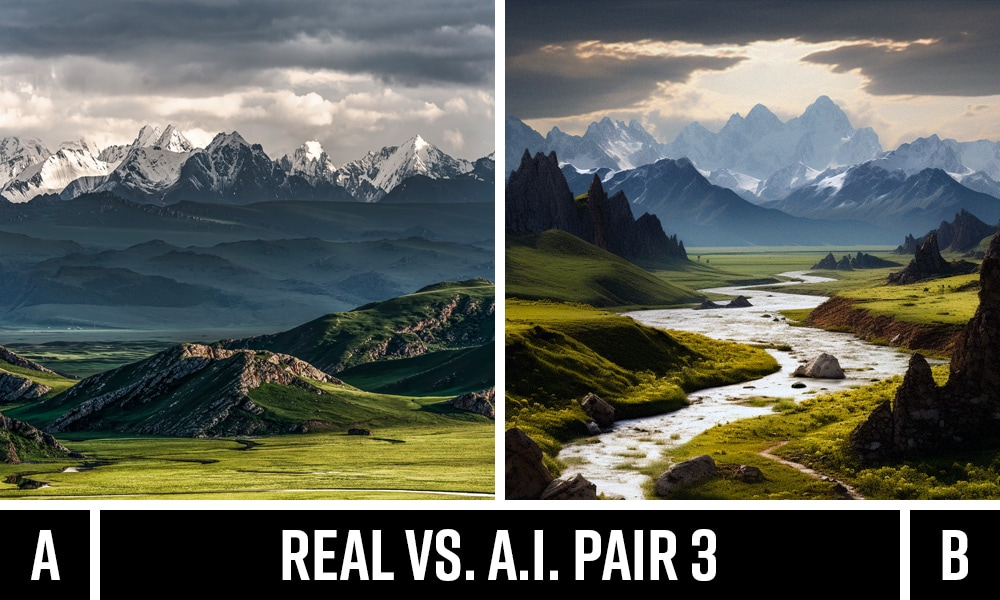

In [ ]:
!pip install kagglehub


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [ ]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download(
    "alessandrasala79/ai-vs-human-generated-dataset"
)

print("Path to dataset files:", path)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import collections
import cv2


In [ ]:
train_data_dir = path

In [ ]:
train_df = pd.read_csv(
    os.path.join(train_data_dir, "train.csv"),
    index_col=0
)

test_df = pd.read_csv(
    os.path.join(train_data_dir, "test.csv")
)

train_df.head()


In [ ]:
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(train_data_dir, x))
train_df['label'] = train_df['label'].astype(str)


In [ ]:
print(train_df['label'].value_counts())


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest',
    validation_split=0.1

)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_name',
    y_col='label',
    class_mode='binary',
    target_size=(128, 128),
    batch_size=32,
    subset='training',
    shuffle=True
)

In [ ]:
val_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_name',
    y_col='label',
    class_mode='binary',
    target_size=(128, 128),
    batch_size=32,
    subset='validation',
    shuffle=False
)

In [ ]:
images, labels = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
labels_list = []

for i in range(5):
    _, labels = next(train_generator)
    labels_list.extend(labels)

label_counts = collections.Counter(labels_list)

plt.bar(['Label 0', 'Label 1'], [label_counts[0], label_counts[1]])
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
augmented_images, _ = next(train_generator)

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle('Augmented Samples')
plt.show()


In [ ]:
unique, counts = np.unique(train_generator.classes, return_counts=True)
print(dict(zip(unique, counts)))


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Find a human-generated image (label 0)
human_image_path = train_df[train_df['label'] == '0']['file_name'].iloc[0]

# Find an AI-generated image (label 1)
ai_image_path = train_df[train_df['label'] == '1']['file_name'].iloc[0]

# Load the images
human_image = Image.open(human_image_path)
ai_image = Image.open(ai_image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(human_image)
plt.title('Human-Generated Image (Label 0)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ai_image)
plt.title('AI-Generated Image (Label 1)')
plt.axis('off')

plt.tight_layout()
plt.show()

# **MLP Model**

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense

In [ ]:
binary_model = Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
binary_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("✅ MLP Model Compiled")
binary_model.summary()

In [ ]:
history_mlp = binary_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    batch_size=32, # Batch size is handled by the generator, but can be specified here as well if needed. Let's keep it consistent.
    verbose=1
)

# **AlexNet-8**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D,
    Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(128, 128, 3))

# ===== AlexNet Conv Layers (5) =====
x = Conv2D(96, (11,11), strides=4, activation='relu', padding='same')(inputs)
x = MaxPooling2D((3,3), strides=2)(x)

x = Conv2D(256, (5,5), activation='relu', padding='same')(x)
x = MaxPooling2D((3,3), strides=2)(x)

x = Conv2D(384, (3,3), activation='relu', padding='same')(x)
x = Conv2D(384, (3,3), activation='relu', padding='same')(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((3,3), strides=2)(x)

# ===== FC Layers (3) =====
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model_AlextNet = Model(inputs, outputs)

model_AlextNet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_AlextNet.summary()



In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)


In [ ]:
history = model_AlextNet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

### AlexNet Training History: Accuracy

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('AlexNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### AlexNet Training History: Loss

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('AlexNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### AlexNet Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_generator.reset()
y_probs_alexnet = model_AlextNet.predict(val_generator, verbose=1)
y_pred_alexnet = (y_probs_alexnet > 0.5).astype(int).ravel()
y_true_alexnet = val_generator.classes

print("📋 AlexNet Classification Report:\n")
print(classification_report(y_true_alexnet, y_pred_alexnet, target_names=['Human', 'AI']))

print("\n🧱 AlexNet Confusion Matrix:")
cm_alexnet = confusion_matrix(y_true_alexnet, y_pred_alexnet)
sns.heatmap(cm_alexnet, annot=True, fmt="d", cmap="Blues", xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("AlexNet Confusion Matrix")
plt.show()

# **VGG 16**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define a VGG16-like model from scratch (not using pre-trained weights or transfer learning)
model_vgg16_scratch = Sequential([
    # ===== Block 1 =====
    Conv2D(64, (3,3), activation='relu', padding='same',
           input_shape=(224,224,3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # ===== Block 2 =====
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # ===== Block 3 =====
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # ===== Block 4 =====
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # ===== Classification Head  =====
    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')   # Binary classification
])

# Compile the model
model_vgg16_scratch.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model_vgg16_scratch.summary()

In [ ]:
history = model_vgg16_scratch.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

### VGG16 Training History: Accuracy

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 Training History: Loss

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_generator.reset()
y_probs_vgg16 = model_vgg16_scratch.predict(val_generator, verbose=1)
y_pred_vgg16 = (y_probs_vgg16 > 0.5).astype(int).ravel()
y_true_vgg16 = val_generator.classes

print("📋 VGG16 Classification Report:\n")
print(classification_report(y_true_vgg16, y_pred_vgg16, target_names=['Human', 'AI']))

print("\n🧱 VGG16 Confusion Matrix:")
cm_vgg16 = confusion_matrix(y_true_vgg16, y_pred_vgg16)
sns.heatmap(cm_vgg16, annot=True, fmt="d", cmap="Blues", xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("VGG16 Confusion Matrix")
plt.show()

# **VGG 16 Transfare Learning**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

for layer in base_model.layers:
    layer.trainable = False

model_vgg16_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model_vgg16_tl.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_vgg16_tl.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


for layer in base_model.layers[-4:]:
    layer.trainable = True

model_vgg16_tl.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)



In [ ]:
history_ft = model_vgg16_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('VGG16 Transfer Learning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)

plt.show()


In [ ]:
for layer in model_vgg16_scratch.layers[-20:]:
    layer.trainable = True

# re compile
model_vgg16_tl.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


fine_tune_history = model_vgg16_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


In [ ]:
val_generator.reset()
y_probs = model_vgg16_tl.predict(val_generator, verbose=1)
y_pred = (y_probs > 0.5).astype(int).ravel()
y_true = val_generator.classes

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Human', 'AI']))

print("\n🧱 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
test_data_dir = "/kaggle/input/ai-vs-human-generated-dataset/test_data_v2"
test_df['file_name'] = test_df['id'].apply(lambda x: os.path.join("/kaggle/input/ai-vs-human-generated-dataset", x))

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_name',
    y_col=None,
    class_mode=None,
    target_size=(128, 128),
    batch_size=32,
    shuffle=False
)


predictions = model.predict(test_generator, verbose=1)

# Assign predicted labels (0 or 1) based on threshold
test_df['label'] = (predictions > 0.5).astype(int)

# Extract image ID from file_name (remove path and extension)
test_df['id'] = test_df['file_name'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# Create the submission DataFrame with required columns
submission = test_df[['id', 'label']]

# Export to CSV file for submission
submission.to_csv('submission.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt

# Get accuracy and val_accuracy separately
acc_before = history.history['accuracy']
val_acc_before = history.history['val_accuracy']
acc_after = fine_tune_history.history['accuracy']
val_acc_after = fine_tune_history.history['val_accuracy']

# Create epochs index
epochs_before = range(1, len(acc_before) + 1)
epochs_after = range(len(acc_before) + 1, len(acc_before) + len(acc_after) + 1)

plt.figure(figsize=(10, 6))

# Plot before fine-tuning
plt.plot(epochs_before, acc_before, 'b--', label='Train Acc (Before Tuning)')
plt.plot(epochs_before, val_acc_before, 'r--', label='Val Acc (Before Tuning)')

# Plot after fine-tuning
plt.plot(epochs_after, acc_after, 'b-', label='Train Acc (After Tuning)')
plt.plot(epochs_after, val_acc_after, 'r-', label='Val Acc (After Tuning)')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Before and After Fine-Tuning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Get training and validation loss
loss_before = history.history['loss']
val_loss_before = history.history['val_loss']
loss_after = fine_tune_history.history['loss']
val_loss_after = fine_tune_history.history['val_loss']

# Create epochs index
epochs_before = range(1, len(loss_before) + 1)
epochs_after = range(len(loss_before) + 1, len(loss_before) + len(loss_after) + 1)

plt.figure(figsize=(10, 6))

# Plot before fine-tuning
plt.plot(epochs_before, loss_before, 'g--', label='Train Loss (Before Tuning)')
plt.plot(epochs_before, val_loss_before, 'orange', linestyle='--', label='Val Loss (Before Tuning)')

# Plot after fine-tuning
plt.plot(epochs_after, loss_after, 'g-', label='Train Loss (After Tuning)')
plt.plot(epochs_after, val_loss_after, 'orange', label='Val Loss (After Tuning)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Before and After Fine-Tuning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

images, labels = next(val_generator)

plt.figure(figsize=(12, 6))

for i in range(5):
    img = images[i]
    img_input = np.expand_dims(img, axis=0)

    prob = model_vgg16_tl.predict(img_input)[0][0]
    pred = "AI" if prob >= 0.5 else "Human"

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{pred}\n{prob:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()